### TRANSMITTER:


TARS sends a msg.

Steps 1: Encoder takes the msg converts to bits(Morse code)

Steps 2: BPSK Modulation

### Baseband to Passband Conversion

### CHANNEL: AWGN

### Passband to Baseband Conversion

### RECEIVER:

Step 1: Demodulation of signal

Step 2:  Decoder decodes it.

Cooper recives message.

In [1]:
#libraries used
import numpy as np
import matplotlib.pyplot as plt
import scipy

In [8]:
# convert the message to morse code( Format given in question of 0s and 1s)
def msg_to_morse(message):
    # Dictionary representing the morse code chart 
    MORSE_CODE_DICT = { 'A':'.-', 'B':'-...', 
                        'C':'-.-.', 'D':'-..', 'E':'.', 
                        'F':'..-.', 'G':'--.', 'H':'....', 
                        'I':'..', 'J':'.---', 'K':'-.-', 
                        'L':'.-..', 'M':'--', 'N':'-.', 
                        'O':'---', 'P':'.--.', 'Q':'--.-', 
                        'R':'.-.', 'S':'...', 'T':'-', 
                        'U':'..-', 'V':'...-', 'W':'.--', 
                        'X':'-..-', 'Y':'-.--', 'Z':'--..', 
                        '1':'.----', '2':'..---', '3':'...--', 
                        '4':'....-', '5':'.....', '6':'-....', 
                        '7':'--...', '8':'---..', '9':'----.', 
                        '0':'-----'} 

    # Convert MORSE dictionary into bits(0s and 1s) as per the format given
    for k in MORSE_CODE_DICT:
        MORSE_CODE_DICT[k]=MORSE_CODE_DICT[k].replace("", "0")[1: -1]   # 1 unit space(0) between parts of same letter
        MORSE_CODE_DICT[k]=MORSE_CODE_DICT[k].replace(".",'1')     # . represents 1 unit : 1
        MORSE_CODE_DICT[k]=MORSE_CODE_DICT[k].replace("-",'111')    # - represents 3 units : 111

    # Function to encrypt the message 
    # according to the morse code chart 
    def encrypt(message): 
        cipher = '' 
        for letter in message: 
            if letter != ' ': 

                # Looks up the dictionary and adds the 
                # correspponding morse code 
                # along with 000 to separate 
                # morse codes for different characters 
                cipher += MORSE_CODE_DICT[letter] + '000'
            else: 
                # 7 0's after each word (3 before+ 4 after) 
                cipher += '0000'

        return cipher 


    encrypt_signal = encrypt(message) 
    encrypt_signal = encrypt_signal[:-3]   # to delete the last 3 000's added in the end
    return encrypt_signal


In [9]:
def modulation(encoded_array):
    #--------Data to be transmitted-------#
    unipolar_arr = encoded_array # unipolar : 0s and 1s
    
    #--------BPSK Mapping to symbols-------#
    # As in a noisy channel the conversion of 0 & 1 is quite possible, we convert it into polar format(+1,-1)
    bipolar = 2*unipolar_arr - 1   # bpsk mapping
    
    #-------Parameters Tuning-------#
    bit_duration = 1
    amplitude_scaling_factor = bit_duration/2  # This will result in unit amplitude waveforms
    
    n_samples = len(encoded_array) * 5   # number of samples to be taken
    time = np.linspace(0, 5, n_samples)  
    samples_per_bit = n_samples/unipolar_arr.size 
    
    #--------Forming Continous pulse-------#
    binary_data = np.repeat(unipolar_arr, samples_per_bit)  # replicate each bit Nsb times
    mapped_data = np.repeat(bipolar, samples_per_bit)
    
    return binary_data,mapped_data,time,n_samples

In [10]:
def bb_to_pb(mapped_array,time):
    #-------Parameters Tuning-------#
    bit_duration = 1
    amplitude_scaling_factor = bit_duration/2  # This will result in unit amplitude waveforms
    freq = 3/bit_duration  # carrier frequency
    waveform = np.sqrt(2*amplitude_scaling_factor/bit_duration) * np.cos(2*np.pi * freq * time)  # carrier signal
    passband_sig = mapped_array*waveform    # modulated signal
    
    return passband_sig

In [13]:
# Define additive white Gaussian noise
def channel(y, snr):
     
    np.random.seed(10)
    snr = 10 ** (snr / 10.0)    # SNR(dB) to linear scale
 
    xpower = np.sum(y ** 2) / len(y)   # signal Power 
 
    npower = xpower / snr   # Noise Power
    
    tx = np.random.randn(len(y)) * np.sqrt(npower) + y  # Add noise to modulated signal
        
    return tx

In [14]:
def pb_to_bb(tx,time):
    #-------Parameters Tuning-------#
    bit_duration = 1
    amplitude_scaling_factor = bit_duration/2  # This will result in unit amplitude waveforms
    freq = 3/bit_duration  # carrier frequency
    
    #-------Carrier Signal---------#
    waveform = np.sqrt(2*amplitude_scaling_factor/bit_duration) * np.cos(2*np.pi * freq * time)  # carrier signal
    
    #-------Demodulation---------#
    base_band_sig=tx*waveform     # demodulated signal
    
    return base_band_sig

In [15]:
def decode(dem,n_samples):
    k=0
    rx=[]
    rx_unipolar=[]
    samples_per_bit=5   #samples per bit taken earlier
    n=int(n_samples/samples_per_bit)
    for i in range(0,n):
        sm=0
        for j in range(0,samples_per_bit):
            sm=sm+dem[k]
            k=k+1
        if(sm>0):
            rx.append(1)
            rx_unipolar.append(1)
        else:
            rx.append(-1)
            rx_unipolar.append(0)
    
    
    rrx = np.repeat(rx, samples_per_bit)    # from pulse
    rx_s=''.join(map(str, rx_unipolar)) 
    time = np.linspace(0, 5, n_samples)

    return rx,rx_s,rrx

In [16]:
def morse_to_msg(rx_s):
    #-----------------------------Dictionary representing the morse code chart------------------------------------------# 
    MORSE_CODE_DICT = { 'A':'.-', 'B':'-...', 
                        'C':'-.-.', 'D':'-..', 'E':'.', 
                        'F':'..-.', 'G':'--.', 'H':'....', 
                        'I':'..', 'J':'.---', 'K':'-.-', 
                        'L':'.-..', 'M':'--', 'N':'-.', 
                        'O':'---', 'P':'.--.', 'Q':'--.-', 
                        'R':'.-.', 'S':'...', 'T':'-', 
                        'U':'..-', 'V':'...-', 'W':'.--', 
                        'X':'-..-', 'Y':'-.--', 'Z':'--..', 
                        '1':'.----', '2':'..---', '3':'...--', 
                        '4':'....-', '5':'.....', '6':'-....', 
                        '7':'--...', '8':'---..', '9':'----.', 
                        '0':'-----'} 

    for k in MORSE_CODE_DICT:
        MORSE_CODE_DICT[k]=MORSE_CODE_DICT[k].replace("", "0")[1: -1]
        MORSE_CODE_DICT[k]=MORSE_CODE_DICT[k].replace(".",'1')
        MORSE_CODE_DICT[k]=MORSE_CODE_DICT[k].replace("-",'111')
    
    #--------------------------------------Detecting words and letters--------------------------------------------------#
    
    #The idea is to detect number of 0's in the signal:
    #if 3 consecutive 0's are found: Replace them by  'L' --> New Letter Found
    #if 7 consecutive 0's are found: Replace them by  'W' --> New Word Found
    
    # param: s(message), newstring('L or W'),index1:index2--> Indices of 0's in the message 
    def replacer(s, newstring, index1,index2):
        if index1 < 0:  # add it to the beginning
            return newstring + s
        if index2 > len(s):  # add it to the end
            return s + newstring

        # insert the new string between "slices" of the original
        return s[:index1] + newstring + s[index2 + 1:]     # all the 0's are replaced by 'L' or 'W' accordingly

   
    rx_msg_1=''
    l=0  # for letter count
    for j in rx_s:
        rx_msg_1=''.join((rx_msg_1,j))
        # Bit joined in rx_msg_1: j
        if j!='0':
            # Bit is  1
            count=0   # for 0's count
            if l==1:  #letter count
                #letter changed
                #change last 3 words to 'L'
                rx_msg_1=replacer(rx_msg_1, 'L',len(rx_msg_1)-4 ,len(rx_msg_1)-2)
                l=0    #make l=0 for avoiding further interference
        else:
            # Bit is  0
            count = count+1    # zero's count increment
            #if 3 0's:Letter may be changed or Words may be changed if 0's get further incremented by 7
            if (count==3):  
                l=1     # letter's count incremented
            else:
                l=0     
            if count==7:
                #print("Word Detected")
                #word changed
                #change the lat 7 words to 'W'
                rx_msg_1=replacer(rx_msg_1, 'W',len(rx_msg_1)-7 ,len(rx_msg_1)-1)
                
                

    #print("Words and Letters Detected: " , rx_msg_1)
     #-------------------------------------Decipher the code-----------------------------------------------------------# 
    # Decrpyt this modified signal
    def decrypt(message): 
  
        # extra space added at the end to access the 
        # last morse code 
        message += ' '

        decipher = '' 
        citext = '' 
        for letter in message: 

            if (letter == '1' or letter == '0'): 
                # storing morse code of a single character 
                citext += letter 

            # in case of letter
            elif letter=='L':
               
                # if i = l that indicates a new letter
                # accessing the keys using their values (reverse of encryption) 
                # Test if element is dictionary value  
                res = citext in MORSE_CODE_DICT.values() 
                if res == 1:
                    decipher += list(MORSE_CODE_DICT.keys())[list(MORSE_CODE_DICT.values()).index(citext)]
                else:
                    decipher += '$' # if due to noise the particular sequence is not found: $ is choosen
                citext = '' 
            
            else: # it is a new word
                # adding space to separate words 
                res = citext in MORSE_CODE_DICT.values()
                if res == 1:
                    decipher += list(MORSE_CODE_DICT.keys())[list(MORSE_CODE_DICT.values()).index(citext)]
                else:
                    decipher += '$'
                decipher += ' '
                citext = '' 


        return decipher 
     #-------------------------------------Return the final decrypted message----------------------------------------# 
    rx_msg=decrypt(rx_msg_1)
    #print(" Final Received Message: ",rx_msg)
    return rx_msg


# MAIN

TARS's Message to Send :  MISSION COMPLETED WHAT IS YOUR STATUS
Encrpted Message :  11101110001010001010100010101000101000111011101110001110100000001110101110100011101110111000111011100010111011101000101110101000100011100010001110101000000010111011100010101010001011100011100000001010001010100000001110101110111000111011101110001010111000101110100000001010100011100010111000111000101011100010101
Recieved message :  11101110001010001010100010101000101010111011101110001110100000001111101110100011101110111000111011100010111011101000101110101000110011100010101110101000000010111011100010101010001011100011100000001010001010100000101110101100111000111011101110001010111000101110100000001010100011100010111000111001101011100010101
 Final Received Message:  MISS$N $OMPL$$ WHAT I$OUR STA$S 


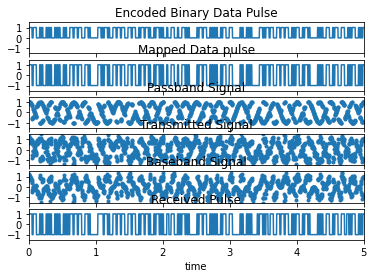

In [17]:
#-------------------------------------------------Transmitter End--------------------------------------------------------#

#-------TARS Sends MSG--------#

message = "MISSION COMPLETED WHAT IS YOUR STATUS"             
print("TARS's Message to Send : ",message)

#--------- Conersion TO Morse Code Bits Pattern:Channel Encoder----------#

encrypt_signal= msg_to_morse(message)
print("Encrpted Message : ",encrypt_signal)
encoded_array = np.array([int(x) for x in encrypt_signal])  # converted string into int array for further purposes

#--------BPSK Modulation-----#

binary_data,mapped_data,time,n_samples = modulation(encoded_array)
mapped_array = np.array([int(x) for x in mapped_data])  # converted string into int array for further purposes
binary_array = np.array([int(x) for x in binary_data])  # converted string into int array for further purposes
#Note: n_samples and time are taken for ease in plotting and visualisation purpose in further steps.

#--------------------------------------Baseband-to-Passband-COnversion----------------------------------------------------#

pass_band=bb_to_pb(mapped_array,time)

#-----------------------------------------------Transmission: AWGN Channel------------------------------------------------#

snr = 10  #set snr value=10dB  (random selection)
tx = channel(pass_band, snr)   # transmitted signal

#-------------------------------------Passband-to-Baseband-COnversion-----------------------------------------------------#

base_band=pb_to_bb(tx,time)

#--------------------------------------------Receiver End-----------------------------------------------------------------#

rx,rx_s,rrx=decode(base_band,n_samples)  # received signal
print("Recieved message : ",rx_s)

#-------Cooper Reads This MSG--------#
message_received = morse_to_msg(rx_s)
print(" Final Received Message: ",message_received)

#-------------------------------------------Plotting----------------------------------------------------------------------#
#------Plotting-------#
f, ax = plt.subplots(6,1, sharex=True, sharey=True)
# plot binary data pulse
ax[0].plot(time, binary_array)  
ax[0].set_title('Encoded Binary Data Pulse')
    
#plot bipolar/mapped pulse
ax[1].plot(time,mapped_array)
ax[1].set_title('Mapped Data pulse')
    
#plot Passband signal
ax[2].plot(time, pass_band, '.')
ax[2].set_title('Passband Signal')

#plot Transmitted Signal
ax[3].plot(time, tx, '.')
ax[3].set_title('Transmitted Signal')

#plot Baseband Signal
ax[4].plot(time, base_band, '.')
ax[4].set_title('Baseband Signal')

#plot Received Signal
ax[5].plot(time, rrx)
ax[5].set_title('Received Pulse')

ax[5].set_xlabel('time')
    
#set axis
ax[0].axis([0, 5, -1.5, 1.5])
plt.show()

### Error rate vs SNR

In [18]:
# finds number of operations to convert str1 to str2
def editDistDP(str1, str2, m, n): 
    # Create a table to store results of subproblems 
    dp = [[0 for x in range(n + 1)] for x in range(m + 1)] 
  
    # Fill d[][] in bottom up manner 
    for i in range(m + 1): 
        for j in range(n + 1): 
  
            # If first string is empty, only option is to 
            # insert all characters of second string 
            if i == 0: 
                dp[i][j] = j    # Min. operations = j 
  
            # If second string is empty, only option is to 
            # remove all characters of second string 
            elif j == 0: 
                dp[i][j] = i    # Min. operations = i 
  
            # If last characters are same, ignore last char 
            # and recur for remaining string 
            elif str1[i-1] == str2[j-1]: 
                dp[i][j] = dp[i-1][j-1] 
  
            # If last character are different, consider all 
            # possibilities and find minimum 
            else: 
                dp[i][j] = 1 + min(dp[i][j-1],        # Insert 
                                   dp[i-1][j],        # Remove 
                                   dp[i-1][j-1])    # Replace 
  
    return dp[m][n] 
  


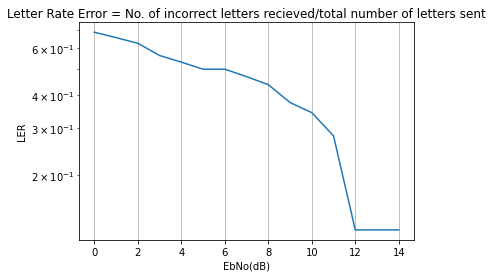

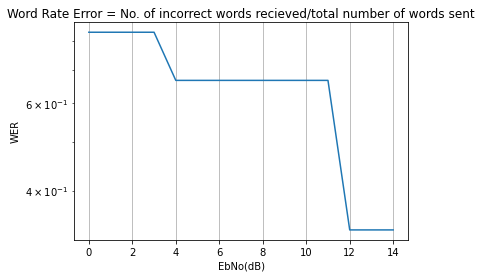

In [22]:
#  Error rate Calculation
#-----------------------------------------Original-Signal Sent is encrypt signal---------------------------------------# 

N=len(message)-message.count(" ")  #total letters in message
N_W=len(message.split())  #total words in message
#----------------------Parameters-----------------------------------------------------------------------------------#
EbNodB_range = range(0,15)   # SNR Varying Range
itr = len(EbNodB_range)
ler = [None]*itr            # letters error rate
wer = [None]*itr            # words error rate

for n in range(0,itr):
    
    #----------------------Transmission: AWGN Channel----------------------#
    snr = EbNodB_range[n]  
    tx = channel(pass_band, snr)   # transmitted signal

    #----------------Passband-to-Baseband-COnversion-----------------------#

    base_band=pb_to_bb(tx,time)

    #------------------------Receiver End------------------------------#

    rx,rx_s,rrx=decode(base_band,n_samples)  # received signal
    #print("Recieved message : ",rx_s)
    
    #-------Cooper Reads This MSG--------#
    message_received = morse_to_msg(rx_s)

    #------------------------Letter Error Rate Calculation------------------------------#
    
    str1 = message_received.replace(" ", "")
    str2 = message.replace(" ", "")

    letter_error=editDistDP(str1, str2, len(str1), len(str2))
    ler[n] = 1.0 * letter_error / N
    #------------------------Word Error Rate Calculation------------------------------#
    A=message
    B=message_received
    un_comm = [i for i in "".join(B).split() if i not in "".join(A).split()] # Finding uncommon words
    word_error=len(un_comm)
    wer[n] = 1.0 * word_error / N_W
    
#----------------------------------------------Plotting------------------------------------------------------------------#

plt.plot(EbNodB_range, ler)
plt.xscale('linear')
plt.yscale('log')
plt.xlabel('EbNo(dB)')
plt.ylabel('LER')
plt.grid(True)
plt.title('Letter Rate Error = No. of incorrect letters recieved/total number of letters sent')
plt.show()       
    
plt.plot(EbNodB_range, wer)
plt.xscale('linear')
plt.yscale('log')
plt.xlabel('EbNo(dB)')
plt.ylabel('WER')
plt.grid(True)
plt.title('Word Rate Error = No. of incorrect words recieved/total number of words sent')
plt.show() 